# Problem Set 4b: Creating a Decision RNN (80 pts)

In this assignment, you will perform a simplified variant of the RNN analyses in Mante*, Sussillo* et al., Nature, 2013 (MS2013). You will train an RNN to perform evidence accumulation (a.k.a. integration), and visualize various features of your trained RNN. Specifically, you will train an RNN to output the running sum of a time-series stimulus input, mimicking the evidence accumulation computation that is central to many simple decision-making tasks. You will visualize the output of the trained RNN on one trial for each stimulus strength, and you will display the condition-averaged activity of a few of the RNN's hidden units. You will then visualize low-dimensional representations of the high-dimensional hidden states of the RNN using PCA and a regression technique akin to Targeted Dimensionality Reduction from MS2013. These visualization techniques are a first step toward understanding how the RNN is representing information and computing on it in a distributed fashion.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

### Part 1: Create the Synthetic Data (5 pts)
First, create the data (inputs and target outputs) used to train the RNN. 

For the inputs, you will generate synthetic time-series stimuli, which represents the time-varying dots stimuli from MS2013. The stimulus will be two-dimensional, one representing motion energy and the other average color. Each time series will be Gaussian noise centered around one of five stimulus strengths. In a neuroscience experiment, these stimulus strengths might be referred to as "conditions" and would allow the experimenter to control the difficulty of each trial.

Draw 40 trials of 25-timestep stimuli for each condition (200 trials total) from unit-variance Gaussians with condition-specific means of {-1, -0.5, 0, 0.5, 1}. Each time step should be independent. You can use the `torch.randn` function to generate samples from a standard Gaussian and then shift by the corresponding mean. When finished, your stimuli should be a single Tensor with shape (200, 25, 2), where the first dimension is the trial index, the second dimension is the sequence time step, and  the third dimension is different context information (motion/color). 

Aside from the stimulus, you will also implement a context cue, which instructs the RNN on which information (motion or color) to base their decisions on. This context cue is either +1 or -1 across the whole trial, and its shape should be (200, 25, 1). Concatenate this with the stimulus, so that you obtain a Tensor of shape (200, 25, 3). This will be the input to your RNN.

To create the target outputs for the RNN, create a running sum of the (first 2 dimensions of the) stimuli across each trial, **according to the context cue**. You can do this with the `torch.cumsum` function. In other words, if context is $+1$, you should have `cumsum(stimulus_motion)` as your target, and if it's $-1$ it should be `cumsum(stimulus_color)`. When finished, your target output should be a Tensor with shape (200, 25, 1).

In [50]:
condition_means = torch.tensor([-1, -0.5, 0, 0.5, 1])
num_conditions = len(condition_means)
num_trials_per_condition = 40
num_trials = num_conditions * num_trials_per_condition
num_timesteps = 25
num_features = 2  

stimuli = []
for mean in condition_means:
    for _ in range(num_trials_per_condition):
        trial = torch.randn(num_timesteps, num_features) + mean
        stimuli.append(trial)

stimuli = torch.stack(stimuli)  

context_cues = torch.randint(0, 2, (num_trials, 1, 1)).float() * 2 - 1  
context_cues = context_cues.repeat(1, num_timesteps, 1)  

inputs = torch.cat((stimuli, context_cues), dim=2)  

target_outputs = []
for trial, context in zip(stimuli, context_cues):
    if context[0, 0] == 1:
        target = torch.cumsum(trial[:, 0], dim=0)
    else:
        target = torch.cumsum(trial[:, 1], dim=0)
        
    target_outputs.append(target)

target_outputs = torch.stack(target_outputs).unsqueeze(-1) 

### Part 2: Implement an RNN class (5 pts)
Implement a class for constructing and running an RNN with a linear readout layer. Your class should inherit from the base class `nn.Module`. Please implement the `__init__` and `forward` methods. The `__init__` method should construct the RNN and readout layer, while the `forward` method should run the RNN and then pass its hidden states through the readout. Make sure that you return both the readout and the RNN hidden states, as we will be analyzing the latter after training the network. Note that you can directly use the RNN class presented in class.

In [51]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, nonlinearity = 'tanh'):
        super().__init__()
        self.rnn = nn.RNN(in_size, hidden_size, batch_first = True, nonlinearity = nonlinearity)
        self.decoder = nn.Linear(hidden_size, out_size)
        
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        batch_size, T, _ = rnn_out.shape
        rnn_out_reshaped = rnn_out.reshape(batch_size * T, -1)
        decoder_out = self.decoder(rnn_out_reshaped)
    
        return decoder_out.reshape(batch_size, T, -1), rnn_out

### Part 3: Implement a Dataset class (5 pts)
Implement a dataset class which inherits from the `Dataset` base class. This module should implement the `__init__`, `__len__`, and `__getitem__` methods. The `__init__` method should store the inputs and outputs (which should already be Tensors) passed via arguments to the method, the `__len__` method should return the size of the dataset, and `__getitem__` should return the datapoint at the given index passed via an argument. Note that you can use the same dataset class from the last homework assignment here, except do not wrap the inputs and outputs in a `torch.tensor`, as they are already Tensors.

In [52]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

### Part 4: Implement the Main Training Loop (10 pts)
Implement a function which iterates through a dataset and trains the model over a specified number of epochs. In addition to what we showed in class, please add gradient clipping by norm using the `nn.utils.clip_grad_norm_` fuction and make the norm value threshold an argument to the training loop function.

As in the previous assignment, create a Python list and append the current average loss at each epoch. You can compute the average loss over all the batches for a given epoch by keeping a running sum of the loss and dividing by the # of batches, which you can get with `len(dataloader)`. Be sure to zero the running sum after each epoch. Also, make sure to append only the value of the average loss to the list using `avg_loss.item()`, which returns the value of the scalar tensor as a standard Python number. 

We also want to keep track of the average magnitude of the gradients during training, which can be an important debugging tool. To get the average gradient magnitude of your network per batch, use the following function after calling the `backward()` method on your loss:

`np.mean([p.grad.norm() for p in model.parameters()])`

Just like with the loss, we want to keep a running average of this quantity each epoch as well and append it to its own separate list. Have the function return the loss and grad_norm lists after training. Additionally, display the epoch, average loss, and average grad_norm to the console every so often, where the display frequency (or period) is an argument to the function. This can be done with a simple `print` statement.

Note that you can use basically the same training loop function from Programming Assignment 2, except you have to be careful to pass the RNN outputs to the loss function, not the hidden states or the network output tuple. Additionally, add gradient clipping by norm and make the norm value threshold an argument to the training loop.

In [53]:
def Main_Training_Loop(data_loader, optimizer, loss_fn, model, num_epochs, amount, clip_thresh):

    avg_losses = []
    avg_grad_mags = []

    for epoch in range(num_epochs):
        sum_losses = 0
        sum_grad_mags = 0

        for batch_idx, batch in enumerate(data_loader):
            input, target = batch
            optimizer.zero_grad()
            output, _ = model(input) 
            loss = loss_fn(output, target)
            sum_losses += loss
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), clip_thresh) 
            sum_grad_mags += np.mean([p.grad.norm() for p in model.parameters()])
            optimizer.step()

        loss_fn.zero_grad()
        avg_loss = (sum_losses / len(data_loader)).item()
        avg_losses.append(avg_loss)

        avg_grad = (sum_grad_mags / len(data_loader)).item()
        avg_grad_mags.append(avg_grad)

        if epoch % amount == 0:
            print("Epoch: ", epoch)
            print("Average Loss: ", avg_loss)
            print("Average Gradient Norm: ", avg_grad)
            print('')
    
    return avg_losses, avg_grad_mags

### Part 5: Construct the Model, Dataset, and Other Bits (5 pts)
First, create a specific RNN using our class. Then create an optimizer (use Adam this time) and pass the parameters of the model as an argument. Additionally, instantiate a loss function for our regression task (MSE loss). Finally, create a dataset using our dataset class and the data you created above. Wrap this dataset in a `DataLoader`, which will handle batching of the data. Please create an RNN which takes in 3 input, has a hidden layer of 128 neurons, has 1 output, and uses a Tanh activation function. Use a learning rate of 1e-4 and a batch size of 200.

In [54]:
model = RNN(3, 128, 1)
optimizer_init = optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.MSELoss()
dataset = MyDataset(inputs, target_outputs)
loader = DataLoader(dataset, batch_size = 200, num_workers = 0)

### Part 6: Train the Model (0 pts)
Train your model using your training loop for 15000 epochs and clipping the gradient norm to a value of 1. 

In [55]:
avg_losses, avg_grad_mags = Main_Training_Loop(data_loader= loader, optimizer= optimizer_init, loss_fn =  loss_fn, model = model, num_epochs = 15000, amount = 1500, clip_thresh = 1)

Epoch:  0
Average Loss:  123.28914642333984
Average Gradient Norm:  0.28869348764419556

Epoch:  1500
Average Loss:  18.195537567138672
Average Gradient Norm:  0.3045075237751007

Epoch:  3000
Average Loss:  10.365421295166016
Average Gradient Norm:  0.26396313309669495

Epoch:  4500
Average Loss:  5.324583053588867
Average Gradient Norm:  0.23854459822177887

Epoch:  6000
Average Loss:  2.076524257659912
Average Gradient Norm:  0.2587163746356964

Epoch:  7500
Average Loss:  1.1509450674057007
Average Gradient Norm:  0.2437211126089096

Epoch:  9000
Average Loss:  0.6653485298156738
Average Gradient Norm:  0.2785904109477997

Epoch:  10500
Average Loss:  0.5075476765632629
Average Gradient Norm:  0.30281317234039307

Epoch:  12000
Average Loss:  0.30356746912002563
Average Gradient Norm:  0.2784900963306427

Epoch:  13500
Average Loss:  0.20281614363193512
Average Gradient Norm:  0.27056068181991577



### Part 7: Generate Average Loss Plot (10 pts)
Plot the average loss and gradient norms during training. Create two subplots with "Epoch" on the x-axis and  "Average Loss" and "Average Gradient Norm" on the y-axes, respectively. For the average loss, use a log scale for the y-axis.

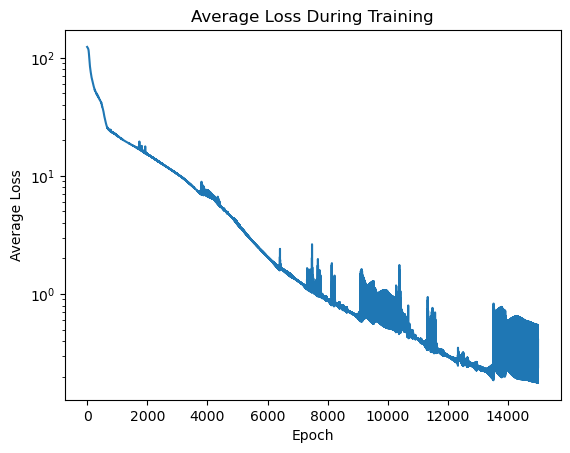

In [56]:
Epoch = np.arange(0, len(avg_losses), 1)

plt.plot(Epoch, avg_losses)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss During Training")
plt.show()

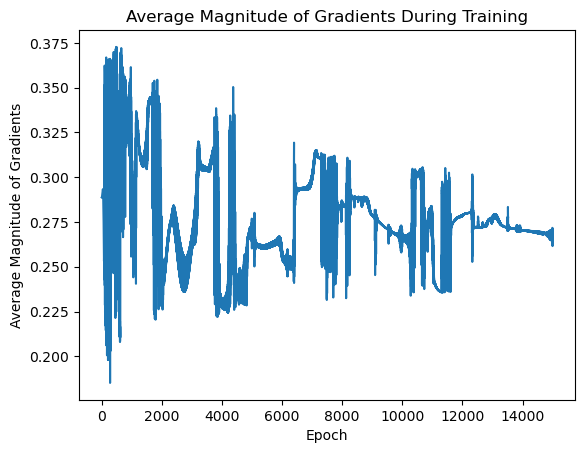

In [57]:
plt.plot(Epoch, avg_grad_mags);
plt.xlabel("Epoch");
plt.ylabel("Average Magnitude of Gradients");
plt.title("Average Magnitude of Gradients During Training");

### Part 8: Visualize Network Outputs (10 pts)
For one trial per stimulus-strength condition, plot the single-trial RNN readout, overlaid with the target output (1 panel per condition --> 5 panels total). To do this, you will have to run the RNN on the stimuli you select and display the RNN's readout. Note that you have to detach the output from the computational graph to plot it. This can either be done with the `detach()` function or by using the `torch.no_grad()` context. Please use a legend on the plot to indicate which is the RNN readout and which is the target output.

torch.Size([200, 25, 1])


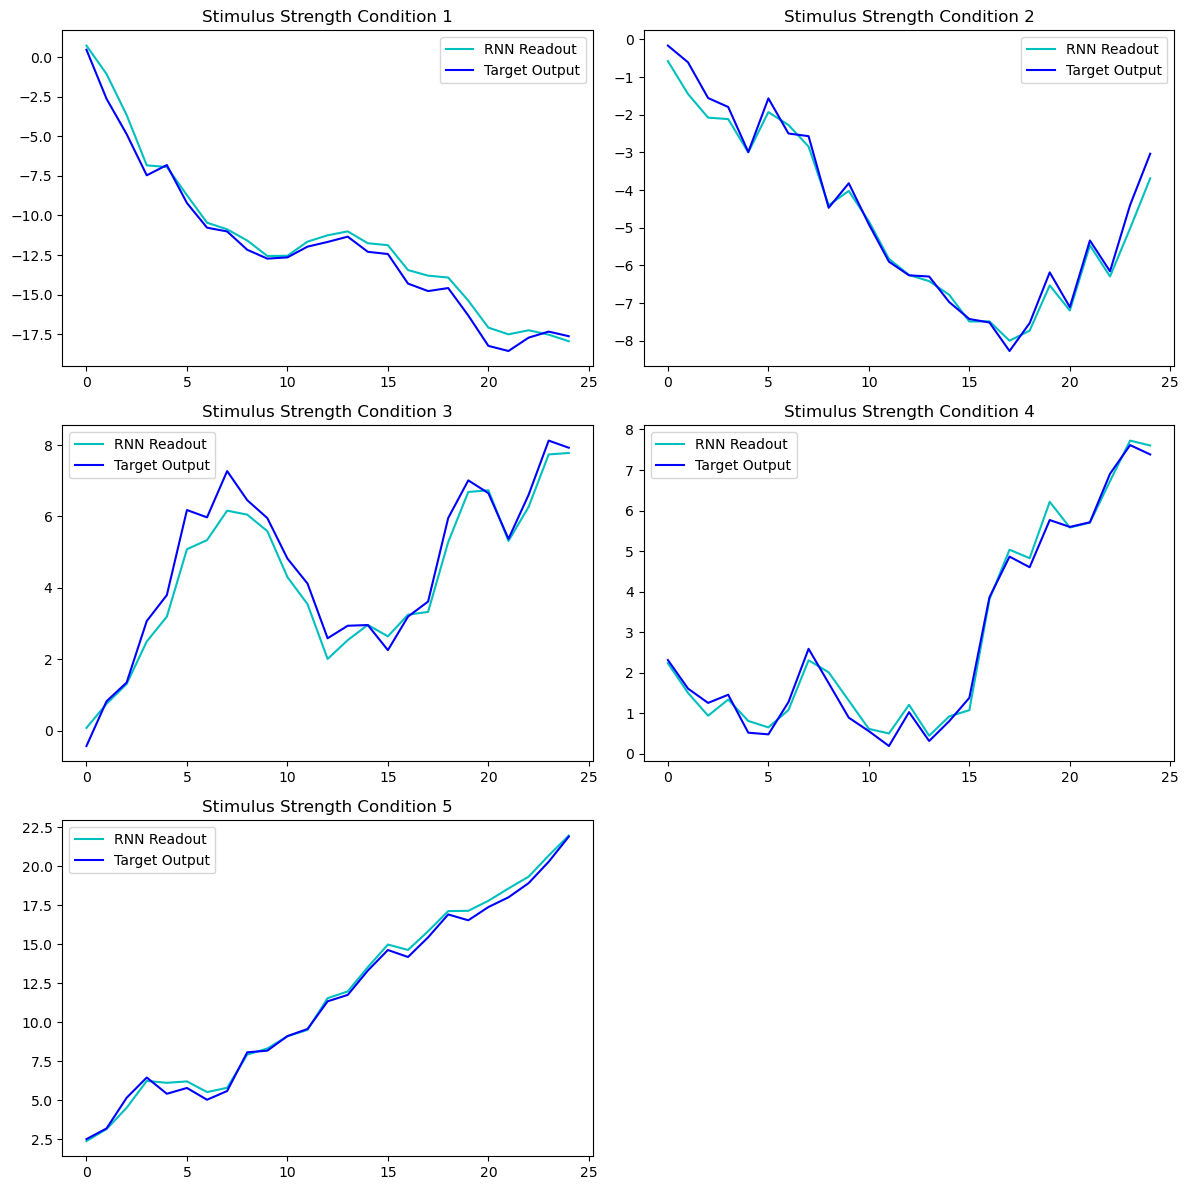

In [67]:
idx_vals = np.arange(0, 200, 40)
output, hidden = model(inputs)
output = output.detach()
hidden = hidden.detach()
print(output.shape)

num_subplots = len(idx_vals)
rows = int(np.ceil(num_subplots / 2))  
cols = 2  

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()

for i, idx in enumerate(idx_vals):
    axes[i].plot(output[idx], label='RNN Readout', color = 'c')
    axes[i].plot(target_outputs[idx], label='Target Output', color = 'b')
    axes[i].set_title(f'Stimulus Strength Condition {i + 1}')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Part 9: Visualize Hidden States (10 pts)
Now plot the condition-averaged activity from 3 individual hidden units (pick any unit that you like). To do this, first run the RNN $^1$ on all trials (if you haven't already stored the result above). Filter for the trials when the context cue is $+1$. Then, for each condition, compute the mean and standard deviation of the hidden states across all trials from that condition. This should involve operating on the first dimension in the Tensor containing the hidden unit activity (i.e., do not average across time steps or hidden units). For each of the hidden units you choose: create a new figure and plot the condition-averaged means and standard deviations $^2$ of the unit's activity. This should result in 5 25-timestep traces overlaid on the figure (one for each condition). Include: a title to indicate the unit #; appropriate axis labels; and a legend to indicate the conditions, labeled by the means of each stimulus distribution. 

Can you find 3 units with distinct representations?

$^1$ Note that you will again have to detach the output from the computational graph (as you will for all proceeding tasks).

$^2$ You can plot the standard deviation using the `fill_between` function in matplotlib.



In [59]:
def contexts(neg_o_pos):
    if neg_o_pos == 1:
        context = np.squeeze(np.where(context_cues[:, 0, 0] == 1))
    if neg_o_pos == -1:
        context = np.squeeze(np.where(context_cues[:, 0, 0] == -1))
    
    cond_1_idx = context[(np.where(context < 40))]
    cond_2_idx = context[(np.where((context > 40) & (context < 80)))]
    cond_3_idx = context[(np.where((context > 80) & (context < 120)))]
    cond_4_idx = context[(np.where((context > 120) & (context < 160)))]
    cond_5_idx = context[(np.where((context > 160) & (context < 200)))]

    return cond_1_idx, cond_2_idx, cond_3_idx, cond_4_idx, cond_5_idx

In [60]:
pos_cond_1_idx, pos_cond_2_idx, pos_cond_3_idx, pos_cond_4_idx, pos_cond_5_idx = contexts(1)
neg_cond_1_idx, neg_cond_2_idx, neg_cond_3_idx, neg_cond_4_idx, neg_cond_5_idx = contexts(-1)

In [61]:
def hidden_state_plots(hidden_layers, cond_1_idx, cond_2_idx, cond_3_idx, cond_4_idx, cond_5_idx):
    num_layers = len(hidden_layers)
    fig, axs = plt.subplots(num_layers, 1, figsize=(10, 6*num_layers))

    for i, hidden_layer in enumerate(hidden_layers):
        mean_1 = np.mean(np.array(hidden[cond_1_idx, :, hidden_layer]), axis=0)
        std_1 = np.std(np.array(hidden[cond_1_idx, :, hidden_layer]), axis=0)

        mean_2 = np.mean(np.array(hidden[cond_2_idx, :, hidden_layer]), axis=0)
        std_2 = np.std(np.array(hidden[cond_2_idx, :, hidden_layer]), axis=0)

        mean_3 = np.mean(np.array(hidden[cond_3_idx, :, hidden_layer]), axis=0)
        std_3 = np.std(np.array(hidden[cond_3_idx, :, hidden_layer]), axis=0)

        mean_4 = np.mean(np.array(hidden[cond_4_idx, :, hidden_layer]), axis=0)
        std_4 = np.std(np.array(hidden[cond_4_idx, :, hidden_layer]), axis=0)

        mean_5 = np.mean(np.array(hidden[cond_5_idx, :, hidden_layer]), axis=0)
        std_5 = np.std(np.array(hidden[cond_5_idx, :, hidden_layer]), axis=0)

        axs[i].plot(mean_1, label='Condition 1')
        axs[i].fill_between(np.arange(25), mean_1 - std_1, mean_1 + std_1, alpha=0.3)
        axs[i].plot(mean_2, label='Condition 2')
        axs[i].fill_between(np.arange(25), mean_2 - std_2, mean_2 + std_2, alpha=0.3)

        axs[i].plot(mean_3, label='Condition 3')
        axs[i].fill_between(np.arange(25), mean_3 - std_3, mean_3 + std_3, alpha=0.3)

        axs[i].plot(mean_4, label='Condition 4')
        axs[i].fill_between(np.arange(25), mean_4 - std_4, mean_4 + std_4, alpha=0.3)

        axs[i].plot(mean_5, label='Condition 5')
        axs[i].fill_between(np.arange(25), mean_5 - std_5, mean_5 + std_5, alpha=0.3)


        axs[i].set_title('Hidden State ' + str(hidden_layer))
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Condition Gaussian Mean')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

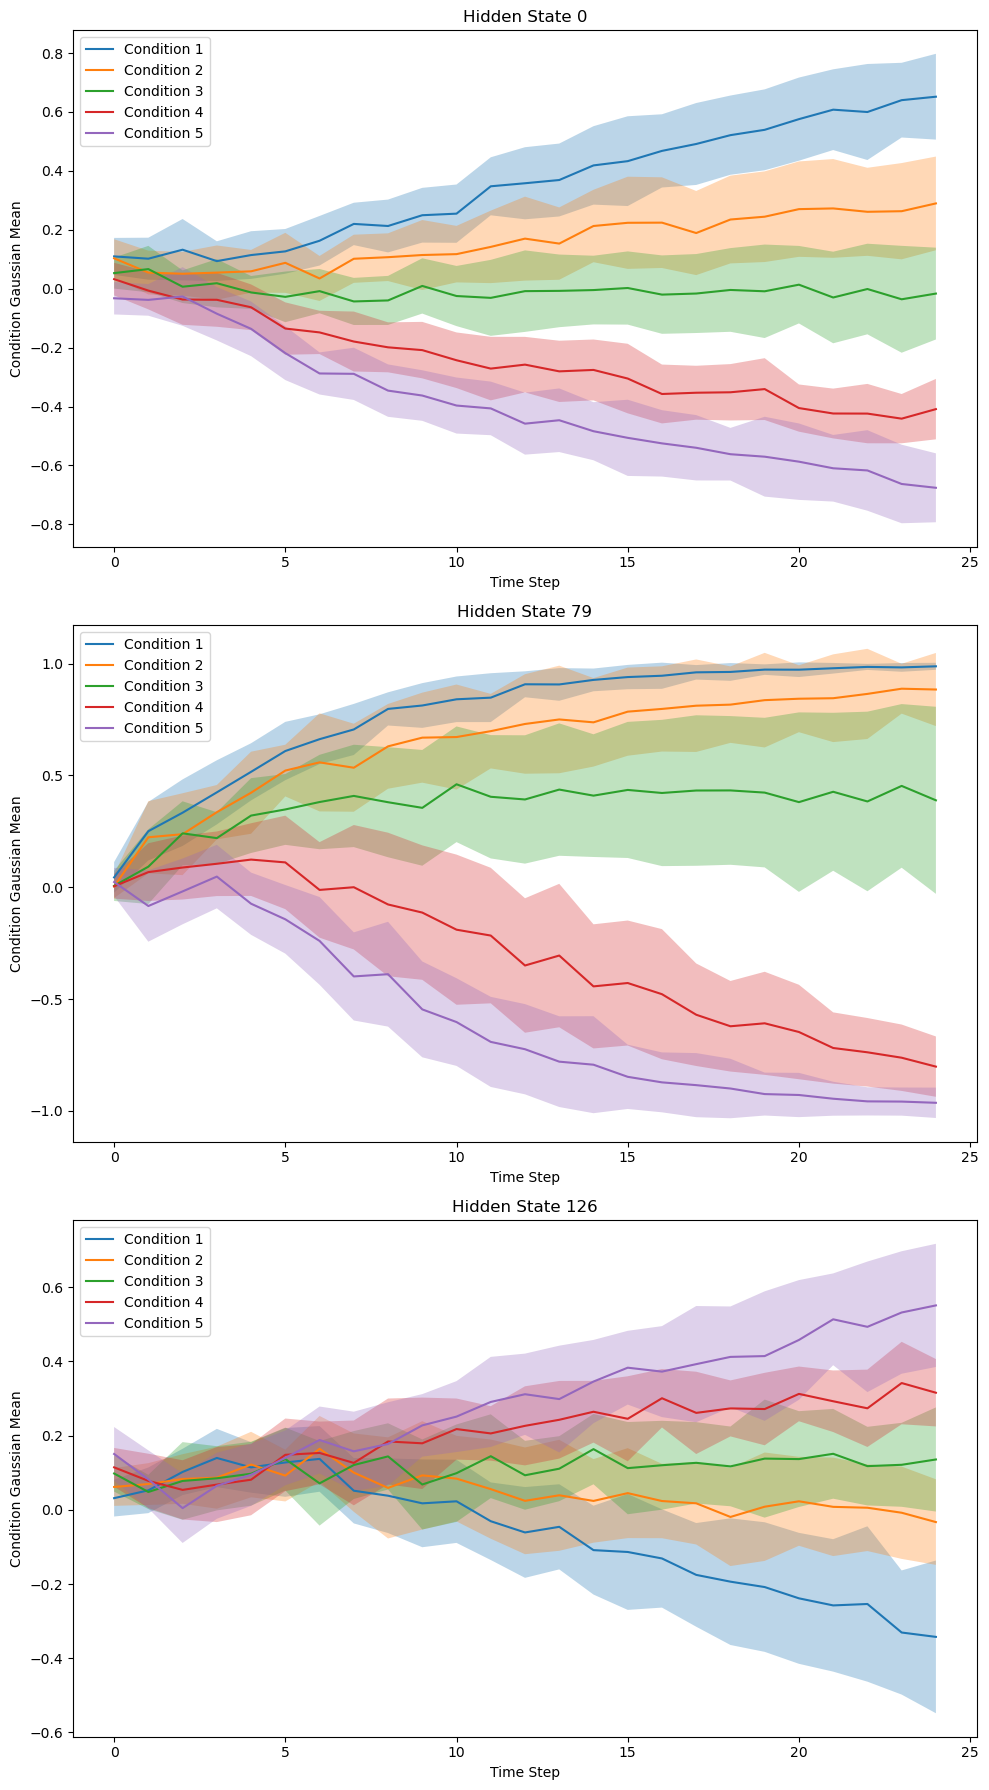

In [62]:
hidden_layers = [0, 79, 126]  
hidden_state_plots(hidden_layers, pos_cond_1_idx, pos_cond_2_idx, pos_cond_3_idx, pos_cond_4_idx, pos_cond_5_idx)

<span style="color:blue">**For the rest of the questions, you can choose**</span> to do either: part 10 + 11, or part 12 only. They will have equal total scores.


### Part 10: Visualize PCA Dimensions of Hidden States (10 pts)

Now run the RNN on the entire dataset and compute the first two principle components of the hidden states. We can compute the principle components using an SVD with `torch.svd`. Note that you will have to reshape the hidden states tensor to be (-1, n_hidden), placing both the batch and sequence time step dimensions together. The SVD function should return three Tensors, which we will call `U`, `S`, and `Vh`. Take the `Vh` tensor, extract the mapping to the first two principle component directions, and then multiply this matrix with the hidden states to get our first two principle components.

For each context ($+1$ or $-1$), filter the trials and plot a separate plot. Similar to above, compute condition-average PCA trajectories: for each condition, average across all trials in that condition, preserving the time (length=25) and features (length=2) dimensions. Plot the condition-averaged PC trajectories on a 2D plot, where the X axis is the first PCA dimension, and the Y axis is the second PCA dimension. For clarity, also include a marker ('o'), which indicates the first timestep of each trajectory. As in the previous section, include a legend to indicate the conditions.

In [63]:
hidden_reshaped = hidden.reshape(-1, 128)

U, S, Vh = torch.svd(hidden_reshaped)

PC_Dir = Vh[:, :2]
first_two_pc = hidden @ PC_Dir

def plot_PCA(Context, cond_1, cond_2, cond_3, cond_4, cond_5):
    first_1 = (np.mean(np.array(first_two_pc[cond_1, :, :]), axis=0)[:, 0])
    second_1 = (np.mean(np.array(first_two_pc[cond_1, :, :]), axis=0))[:, 1]
    plt.scatter(first_1[0], second_1[0], marker = 'o')
    plt.plot(first_1, second_1, label = 'Condition 1')

    first_2 = (np.mean(np.array(first_two_pc[cond_2, :, :]), axis=0)[:, 0])
    second_2 = (np.mean(np.array(first_two_pc[cond_2, :, :]), axis=0))[:, 1]
    plt.scatter(first_2[0], second_2[0], marker = 'o')
    plt.plot(first_2, second_2, label = 'Condition 2')

    first_3 = (np.mean(np.array(first_two_pc[cond_3, :, :]), axis=0)[:, 0])
    second_3 = (np.mean(np.array(first_two_pc[cond_3, :, :]), axis=0))[:, 1]
    plt.scatter(first_3[0], second_3[0], marker = 'o')
    plt.plot(first_3, second_3, label = 'Condition 3')

    first_4 = (np.mean(np.array(first_two_pc[cond_4, :, :]), axis=0)[:, 0])
    second_4 = (np.mean(np.array(first_two_pc[cond_4, :, :]), axis=0))[:, 1]
    plt.scatter(first_4[0], second_4[0], marker = 'o')
    plt.plot(first_4, second_4, label = 'Condition 4')

    first_5 = (np.mean(np.array(first_two_pc[cond_5, :, :]), axis=0)[:, 0])
    second_5 = (np.mean(np.array(first_two_pc[cond_5, :, :]), axis=0))[:, 1]
    plt.scatter(first_5[0], second_5[0], marker = 'o')
    plt.plot(first_5, second_5, label = 'Condition 5')

    plt.legend()
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(Context + ' Context')


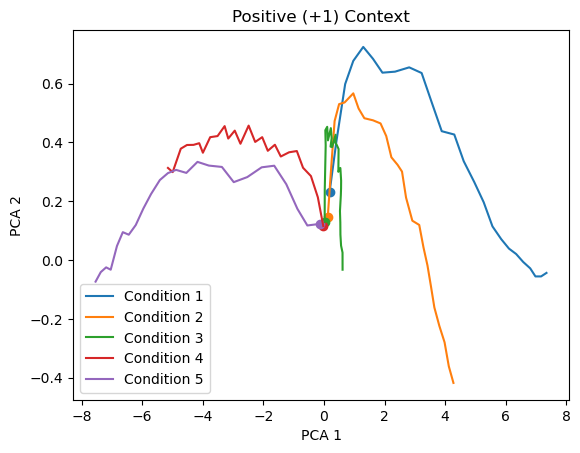

In [64]:
plot_PCA('Positive (+1)', pos_cond_1_idx, pos_cond_2_idx, pos_cond_3_idx, pos_cond_4_idx, pos_cond_5_idx)

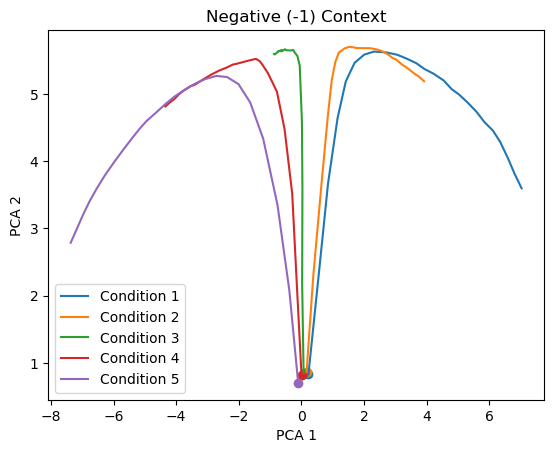

In [65]:
plot_PCA('Negative (-1)', neg_cond_1_idx, neg_cond_2_idx, neg_cond_3_idx, neg_cond_4_idx, neg_cond_5_idx)

### Part 11: Identifying the dimension in the hidden states that best relates to stimulus strength (10 pts)
Finally, we will use ridge regression to identify the dimension in the space of the RNN hidden states that best predicts stimulus strength. This is similar to the Targeted Dimensionality Reduction (TDR) approach used in Mante*, Sussillo* et al., Nature, 2013. 

---------------
**Ridge Regression.**
To create your regression inputs, take the hidden states of the network for the whole dataset and stack them in a (num_trials*num_timesteps, num_units) matrix. To create your regression targets, use the stimulus strengths (means of condition-specific Gaussians) that correspond to each (trial, time) in the leading dimension of the regression inputs. You can use any method you want to compute ridge regression model, but it is straightforward to implement it manually. If you implement it manually, make sure to appropriately append ones to the regression inputs to allow an offset term. The optimal parameters estimate of a ridge regression model is:

$W = (X^T X + \lambda I)^{-1} X^T Y$

Note that this is equivalent to linear regression with L2 regularization on the parameters. Use an L2 scaling of $\lambda=0.1$. Once you fit the model, extract the weights and the bias. Now apply the linear model to the hidden states, and plot the condition-averaged results versus time. 

---------------

You should produce a figure in the style of Part 9, but here the y-axis indicates activity along the stimulus-strength dimension. Again, filter for trials where context is $+1$.

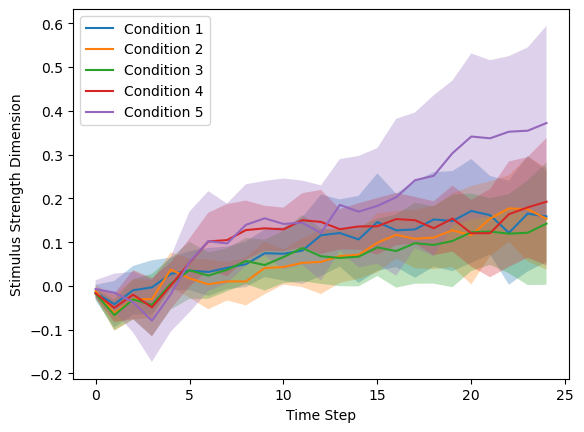

In [66]:
X = np.array(hidden.reshape(200*25, 128))
ones = np.ones((X.shape[0], 1))
X_s = np.hstack((X, ones))

reg_targets = np.array(([-1] * 40 + [-0.5] * 40 + [0] * 40 + [0.5] * 40 + [1] * 40) * 25)

lambda_v = 0.1

I = np.identity(X_s.shape[1])
W = np.linalg.inv(X_s.T @ X_s + (lambda_v * I)) @ X_s.T @ reg_targets

weights = W[:-1]
bias = W[-1]

modeled = X @ weights + bias

modeled = modeled.reshape(200, 25)

mean_1 = np.mean(modeled[pos_cond_1_idx, :], axis = 0)
std_1 = np.std(modeled[pos_cond_1_idx, :], axis = 0)

mean_2 = np.mean(modeled[pos_cond_2_idx, :], axis = 0)
std_2 = np.std(modeled[pos_cond_2_idx, :], axis = 0)

mean_3 = np.mean(modeled[pos_cond_3_idx, :], axis = 0)
std_3 = np.std(modeled[pos_cond_3_idx, :], axis = 0)

mean_4 = np.mean(modeled[pos_cond_4_idx, :], axis = 0)
std_4 = np.std(modeled[pos_cond_4_idx, :], axis = 0)

mean_5 = np.mean(modeled[pos_cond_5_idx, :], axis = 0)
std_5 = np.std(modeled[pos_cond_5_idx, :], axis = 0)

plt.plot(mean_1, label = 'Condition 1')
plt.plot(mean_2, label = 'Condition 2')
plt.plot(mean_3, label = 'Condition 3')
plt.plot(mean_4, label = 'Condition 4')
plt.plot(mean_5, label = 'Condition 5')

plt.fill_between(np.arange(25), mean_1 - std_1, mean_1 + std_1, alpha = 0.3)
plt.fill_between(np.arange(25), mean_2 - std_2, mean_2 + std_2, alpha = 0.3)
plt.fill_between(np.arange(25), mean_3 - std_3, mean_3 + std_3, alpha = 0.3)
plt.fill_between(np.arange(25), mean_4 - std_4, mean_4 + std_4, alpha = 0.3)
plt.fill_between(np.arange(25), mean_5 - std_5, mean_5 + std_5, alpha = 0.3)

plt.legend(loc = 'upper left');
plt.xlabel("Time Step");
plt.ylabel("Stimulus Strength Dimension");